### Load data

In [8]:
from utils.process_tensors import load_tensor, normalize_tensor
import tensorflow as tf

batch_size = 128
train_ratio = .8

file_names = [ "test2", "test3", "test4"]
input_tensor = None
output_tensor = None
for file_name in file_names:
    load_path = f"./data/{file_name}/"
    input_path = load_path + "input"
    output_path = load_path + "output"
    x = load_tensor(input_path, out_type=tf.int32)
    y = load_tensor(output_path, out_type=tf.float32)
    if input_tensor is None:
        input_tensor = x
        output_tensor = y
    else:
        input_tensor = tf.concat([input_tensor, x], axis=0)
        output_tensor = tf.concat([output_tensor, y], axis=0)
print(tf.math.reduce_min(output_tensor), tf.math.reduce_max(output_tensor))
output_tensor = normalize_tensor(output_tensor)

dataset:tf.data.Dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor))
print('nb_positions:',dataset.cardinality().numpy())
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(1)

train_size = int(dataset.cardinality().numpy() * train_ratio)
test_size = int(dataset.cardinality().numpy() * (1 - train_ratio) / 2)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)


tf.Tensor(-99.99, shape=(), dtype=float32) tf.Tensor(99.99, shape=(), dtype=float32)
nb_positions: 22150


In [2]:
print('train:',train_dataset.cardinality().numpy())
print('test:',test_dataset.cardinality().numpy())


train: 220
test: 56


In [3]:
from utils.build_model import build_model

model = build_model(16, 3, (7, 8, 8))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 8, 16)          1168      
                                                                 
 dropout (Dropout)           (None, 7, 8, 16)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 8, 16)          2320      
                                                                 
 dropout_1 (Dropout)         (None, 7, 8, 16)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 8, 16)          2320      
                                                                 
 dropout_2 (Dropout)         (None, 7, 8, 16)          0         
                                                                 
 flatten (Flatten)           (None, 896)               0

In [4]:
import os
from utils.callback_setup import callback_setup

checkpoint_name = "test_3_layers_4/"
checkpoint_filepath = os.path.join('backup', checkpoint_name)

model_callbacks = callback_setup(checkpoint_filepath)

### Load Weights

In [5]:
# checkpoint_name = "test_3_layers/"
# checkpoint_filepath = os.path.join('backup', checkpoint_name)

# model.load_weights(checkpoint_filepath)

In [6]:
history = model.fit(train_dataset,
                    epochs=40,
                    validation_data=(test_dataset),
                    verbose=1,
                    callbacks=model_callbacks
                    )

Epoch 1/40


220/220 [==============================] - 5s 16ms/step - loss: 0.0846 - val_loss: 0.0717
Epoch 2/40
220/220 [==============================] - 4s 16ms/step - loss: 0.0746 - val_loss: 0.0699
Epoch 3/40
220/220 [==============================] - 4s 17ms/step - loss: 0.0706 - val_loss: 0.0653
Epoch 4/40
220/220 [==============================] - 4s 16ms/step - loss: 0.0677 - val_loss: 0.0637
Epoch 5/40
220/220 [==============================] - 4s 16ms/step - loss: 0.0659 - val_loss: 0.0632
Epoch 6/40
220/220 [==============================] - 4s 17ms/step - loss: 0.0649 - val_loss: 0.0631
Epoch 7/40
220/220 [==============================] - 4s 16ms/step - loss: 0.0647 - val_loss: 0.0620
Epoch 8/40
220/220 [==============================] - 4s 16ms/step - loss: 0.0631 - val_loss: 0.0626
Epoch 9/40
220/220 [==============================] - 4s 17ms/step - loss: 0.0623 - val_loss: 0.0614
Epoch 10/40
220/220 [==============================] - 4s 16ms/step - loss: 0.0616 - val_loss: 0.0611


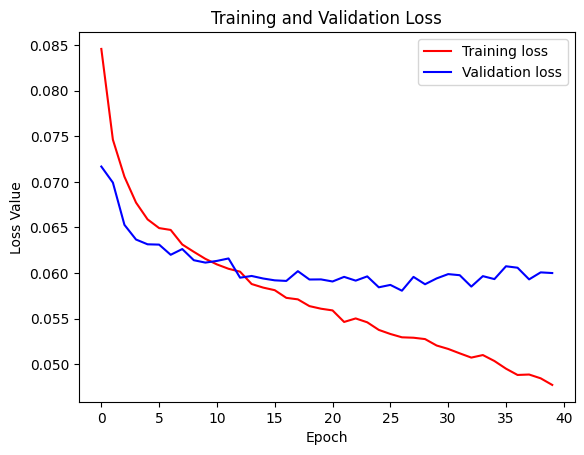

In [7]:
from utils.plot_loss import plot_loss
plot_loss(history.epoch, history.history["loss"], history.history["val_loss"])

In [16]:
from utils.random_board import generate_random_board
from utils.process_board import convert_board_to_array
from utils.stockfish import get_score
import random

k = random.randrange(0, 1000)
n = 1

x_test = input_tensor[k:k+n,:,:,:]
y_test = output_tensor[k:k+n]

y_pred = model.predict(x_test)

print("y_test: ", y_test*99.99)
print("y_pred: ", y_pred[:,0]*100)




1/1 [==============================] - 0s 20ms/step
y_test:  tf.Tensor([-1.3], shape=(1,), dtype=float32)
y_pred:  [-2.5581093]


In [61]:
board = generate_random_board()
score = get_score(board)
x_test = tf.convert_to_tensor(convert_board_to_array(board))
x_test = tf.expand_dims(x_test, axis=0)

y_predict = model.predict(x_test)

print("y_pred: ", y_predict[0,0]*100)
print("y_true: ", score)


1/1 [==============================] - 0s 20ms/step
y_pred:  -79.76203560829163
y_true:  -99.98


: 